# 人脸识别

在本案例中，我们将利用模型MTCNN以及FaceNet进行人脸比对，得出人脸相似程度，判断图片是否是同一个人。

### MTCNN (Multi-task convolutional neural network)多任务卷积神经网络

人脸检测作为识别过程的第一步，负责了将人脸区域从图片中检测出来。MTCNN是一种应用广泛的人脸区域检测模型，通过三个网络：PNet， RNet， ONet，将人脸所在的区域坐标以及人脸关键点（眼鼻口）坐标检测出来。
![MTCNN](./img/M-nw.png)
三个网络都是卷积神经网络，PNet将人脸区域做出提取，此时的区域准确性低，数量很多，接着通过NMS进行过滤。接着是RNet，拥有更多的网络结构，提取的特征更加准确，预测框更少，接着通过NMS得出人脸区域检测。最后，ONet通过最多的网络结构进行提取，输出人脸区域以及人脸特征点信息。

![MTCNN](./img/mtcnn-1.png)
在本案例中，MTCNN的目的是人脸检测，所以只处理人脸区域坐标。


### FaceNet
FaceNet通过GoogLeNet将人脸进行特征提取，提取到128维特征图，通过对比不同人脸图片在128维特征点间的欧几里得距离，距离较近的人脸图片可以看作是同一个人，距离为零时是同一张图片。作为一种将深度学习技术到人脸领域的应用，FaceNet十分成功，它超越了传统的机器学习算法，在处理精度上有很大提升。
![FaceNet](./img/FN-str-1.png)

##### 案例讲解图片以及预训练模型来自论文及开源
[MTCNN](https://kpzhang93.github.io/MTCNN_face_detection_alignment/index.html)

[FaceNet](https://github.com/davidsandberg/facenet)

[FaceNet](https://arxiv.org/abs/1503.03832)

创建华为云ModelArts运行环境：
![MA](./img/MA.png)

In [8]:
from modelarts.session import Session
session = Session()
session.download_data("modelarts-labs/notebook/DL_face_recognition_advanced/face_recognition_advanced.tar.gz","./face_recognition_advanced.tar.gz")
!tar -xvf face_recognition_advanced.tar.gz

Successfully download file modelarts-labs/end2end/face/face.tar.gz from OBS to local ./face.tar.gz
20170512-110547/
20170512-110547/20170512-110547.pb
20170512-110547/model-20170512-110547.ckpt-250000.data-00000-of-00001
20170512-110547/model-20170512-110547.ckpt-250000.index
20170512-110547/model-20170512-110547.meta
img_3.jpeg
./._img_didi.jpeg
img_didi.jpeg
img_nana_1.jpg
img_nana_2.jpeg
./._img_nini.jpeg
img_nini.jpeg
src/
src/._.DS_Store
src/.DS_Store
src/._align
src/align/
src/facenet.py
src/align/._.DS_Store
src/align/.DS_Store
src/align/.___init__.py
src/align/__init__.py
src/align/._align_dataset_mtcnn.py
src/align/align_dataset_mtcnn.py
src/align/._det1.npy
src/align/det1.npy
src/align/._det2.npy
src/align/det2.npy
src/align/._det3.npy
src/align/det3.npy
src/align/detect_face.py


#### 打开图片
在这个案例中，我们将让计算机来分辨欧阳妮妮，欧阳娜娜以及欧阳娣娣三姐妹，为了体现测试数据的多样性，我们加入腾格尔作为对照。

我们首先找到两张欧阳娜娜的照片：

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import math
import tensorflow as tf
import scipy.misc as misc
import copy
import os
import cv2
import numpy as np
import src.facenet as facenet
import src.align.detect_face as detect_face
%matplotlib inline

In [2]:
# 函数show_images 负责将图片显示出来
# images_list 图片路径集合
# images_names 图片名称集合，顺序与大小与图片路径保持一致
def show_images(images_list, images_names):
    if len(images_list) != len(images_names):
        print("图片名和图片数量不符")
    else:
        l = len(images_list)
        #确定行列数
        #固定为2列
        line =  math.ceil(l/2)
        for i in range(l):
            plt.rcParams['savefig.dpi'] = 200 #图片像素
            plt.rcParams['figure.dpi'] = 150 #分辨率
            plt.subplot(line,2,i+1)
            plt.imshow(Image.open(images_list[i]))
            plt.title(images_names[i],fontsize = 10)
            plt.axis('off')


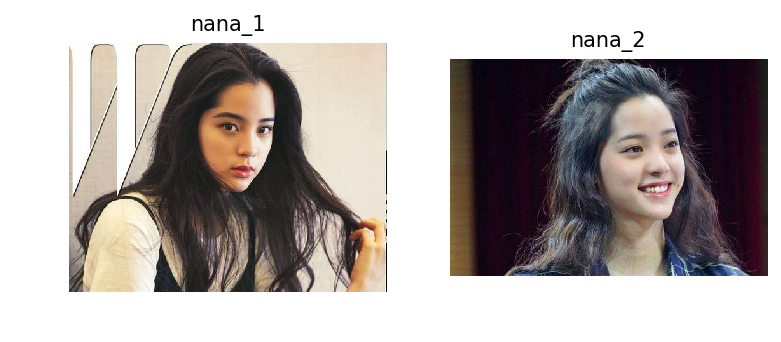

In [12]:
images_list =  ["./img_nana_1.jpg","./img_nana_2.jpeg"]
images_names = ["nana_1","nana_2"]
show_images(images_list,images_names)

接下来我们找到欧阳娜娜的姐妹：欧阳妮妮和欧阳娣娣的照片

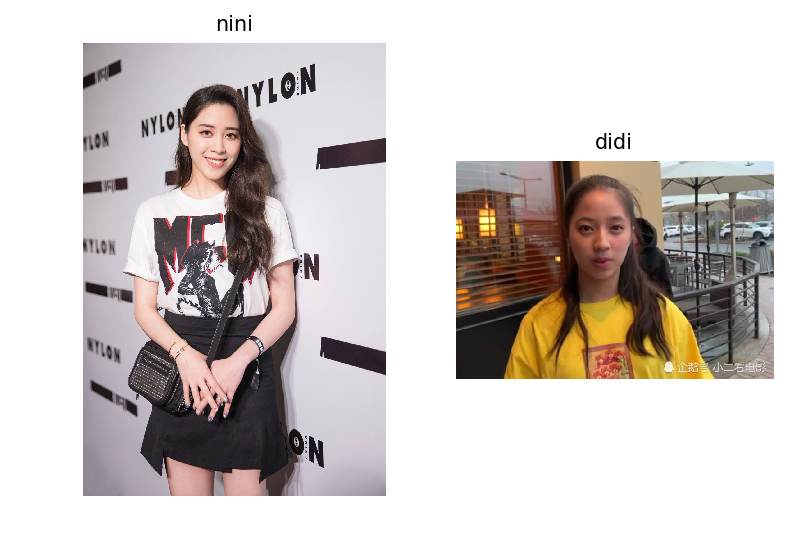

In [4]:
images_list =  ["./img_nini.jpeg","./img_didi.jpeg"]
images_names = ["nini","didi"]
show_images(images_list,images_names)

那么我们也找一张腾格尔的照片ヽ(✿ﾟ▽ﾟ)ノ：

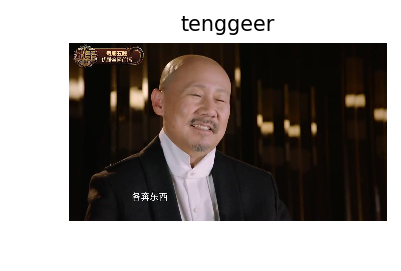

In [5]:
images_list =  ["./img_3.jpeg"]
images_names = ["tenggeer"]
show_images(images_list,images_names)

开始进行人脸比对，首先将人脸区域划分出来。将所有的文件路径加入到image_path中，

In [6]:
image_path = ["./img_nana_1.jpg","./img_nana_2.jpeg","./img_nini.jpeg","./img_didi.jpeg","./img_3.jpeg"]
image_name = ["nana_1","nana_2","nini","didi","tenggeer"]

进行人脸区域检测。人脸区域检测模型MTCNN，分为PNet， RNet以及ONet， 三种卷积神经网络，加入NMS，完成对人脸的检测。

In [7]:
minsize = 20 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor
tmp_image_paths=copy.copy(image_path)
img_list = [] 
mtcnn_list = []
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, None)
margin = 44
image_size = 160
for image in tmp_image_paths:
#     img = misc.imread(os.path.expanduser(image), mode='RGB')
    img = Image.open(image)
    img = np.array(img)
    img_size = np.asarray(img.shape)[0:2]
    bounding_boxes, _ = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
    if len(bounding_boxes) < 1:
        image_paths.remove(image)
        continue
    det = np.squeeze(bounding_boxes[0,0:4])
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(det[0]-margin/2, 0)
    bb[1] = np.maximum(det[1]-margin/2, 0)
    bb[2] = np.minimum(det[2]+margin/2, img_size[1])
    bb[3] = np.minimum(det[3]+margin/2, img_size[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    mtcnn_list.append(cropped)
    aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
    prewhitened = facenet.prewhiten(aligned)
    img_list.append(prewhitened)
images = np.stack(img_list)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


人脸检测结果如下所示：

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


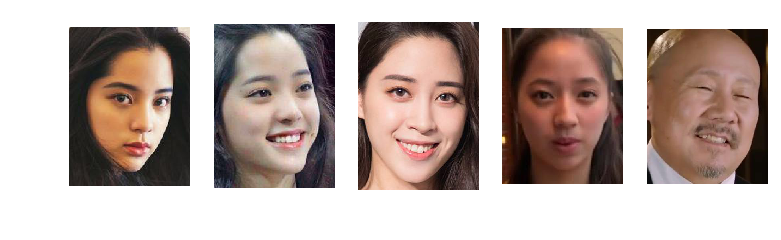

In [8]:
l = len(mtcnn_list)
line =  1
for i in range(l):
    plt.rcParams['savefig.dpi'] = 100 #图片像素
    plt.rcParams['figure.dpi'] = 150 #分辨率
    plt.subplot(1,l,i+1)
    plt.imshow(Image.fromarray(mtcnn_list[i]))
    plt.axis('off')
    plt.rcParams['font.sans-serif']=['SimHei']

将人脸检测结果放入FaceNet模型，得到预测结果。

In [9]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        facenet.load_model("./20170512-110547/20170512-110547.pb")
        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        
        feed_dict = { images_placeholder: images, phase_train_placeholder:False }
        emb = sess.run(embeddings, feed_dict=feed_dict)
        nrof_images = len(image_path)

        data = []
        data_item = []
        for i in range(nrof_images):
            for j in range(nrof_images):
                if j<i:
                    data_item.append(""+str(image_name[i])+"&"+str(image_name[j]))
                    dist = np.sqrt(np.sum(np.square(np.subtract(emb[i,:], emb[j,:]))))
                    data.append(dist)

Model filename: ./20170512-110547/20170512-110547.pb
Instructions for updating:
Use tf.gfile.GFile.


将运行结果绘制出来，可以看到数值最低的是娜娜本人两张相同的照片，姐妹照片的数值处于中间值，而数值最高的是腾格尔的照片与三姐妹的照片相比。

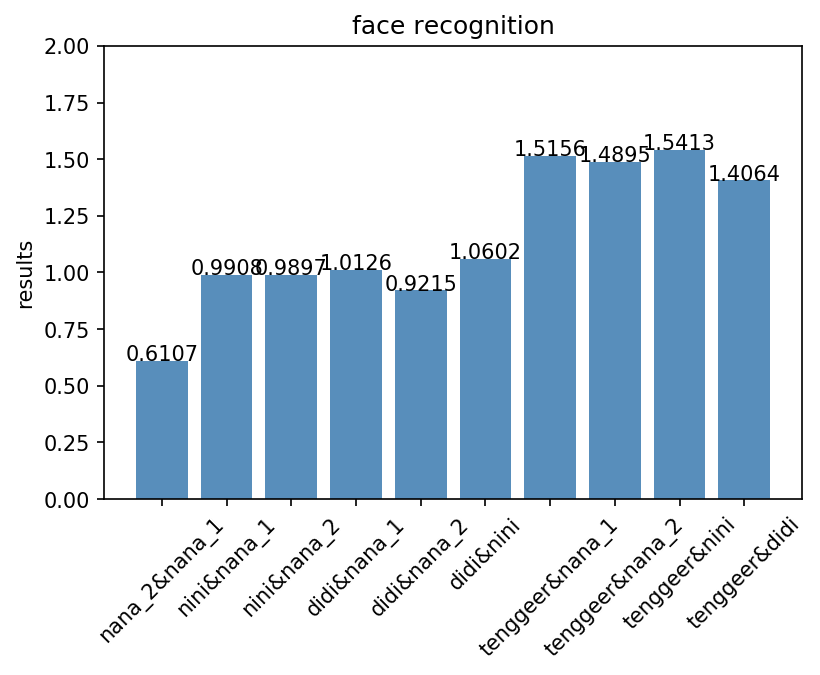

In [10]:
plt.bar(range(len(data)), data, align = 'center',color='steelblue', alpha = 0.9)
plt.ylabel('results')
plt.title('face recognition')
plt.xticks(range(len(data)),data_item,rotation=45)
plt.ylim([0,2])
  
for x,y in enumerate(data):
    plt.text(x,y,'%1.4f' %y,ha='center')# 显示图形plt.show()

plt.show()
